In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def project_parameters(*args):
    def build_red_fn(fn):
        def wrapped_fn(params):
            subselected_params = [params[a] for a in args]
            return fn(*subselected_params), args
        return wrapped_fn
    return build_red_fn

In [3]:
@project_parameters(0, 1, 3)
def my_fn(a, b, c):
    return a+b+c

In [4]:
output = my_fn([0.3, 0.5, 0.6, 0.7])

In [5]:
print(output)

(1.5, (0, 1, 3))


# Test the pairplot

In [23]:
from torch.distributions import MultivariateNormal, Normal
from sbi.utils import eval_conditional_density, pairplot, conditional_pairplot
import matplotlib.pyplot as plt
import torch

In [24]:
# d = MultivariateNormal(torch.zeros(3), torch.tensor([[1.0, 0.95, 0.95], [0.95, 1.0, 0.95], [0.95, 0.95, 1.0]]))
d = MultivariateNormal(torch.tensor([10., 5, 1]), torch.tensor([[100.0, 0, 0], [0, 10.0, 0], [0, 0, 1.0]]))
d = MultivariateNormal(torch.tensor([0.6, 5.0]), torch.tensor([[0.1, 0.99], [0.99, 10.0]]))

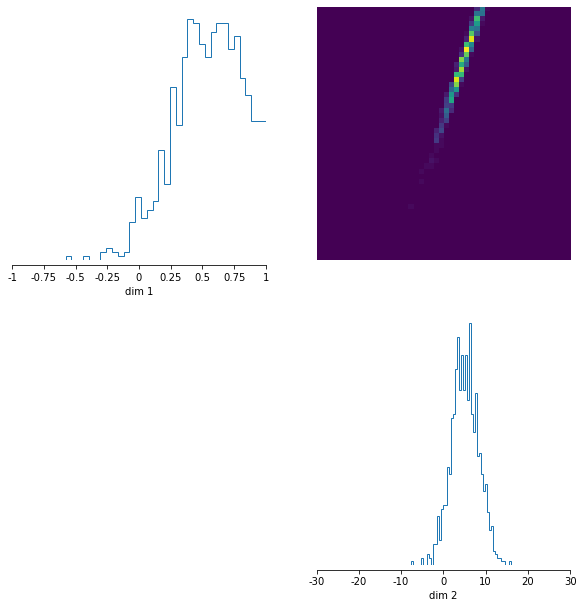

In [25]:
fig, ax = pairplot(
    samples = d.sample((1000,)),
    limits = torch.tensor([[-1.0, 1.0], [-30, 30]]),
#     upper = ['cond'],
#     diag = ['cond']
)

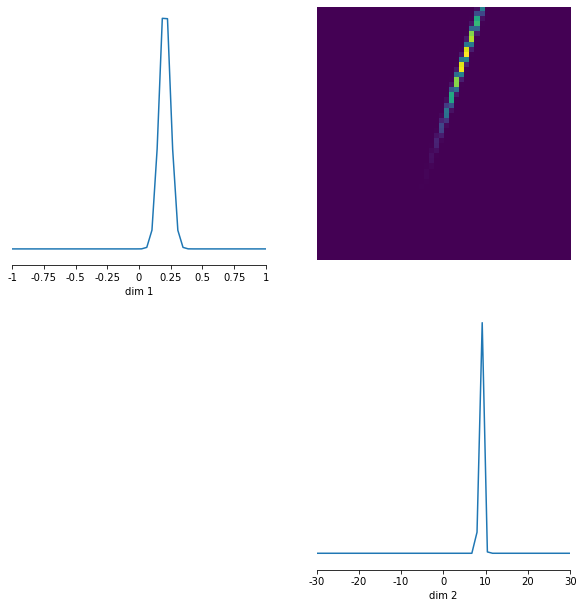

In [30]:
_ = conditional_pairplot(
    density=d,
    condition = torch.ones(1, 2),
    limits = torch.tensor([[-1.0, 1.0], [-30, 30]]),
)

In [10]:
from sbi.utils import conditional_corrcoeff, av_conditional_corr_matrix

In [11]:
d = MultivariateNormal(torch.tensor([0.6, 5.0]), torch.tensor([[0.1, 0.99], [0.99, 10.0]]))

In [12]:
corr = conditional_corrcoeff(
    density=d,
    condition = torch.ones(1, 2),
    limits = torch.tensor([[-3.0, 3.0], [-90, 90]]),
    dim1=0,
    dim2=1,
    resolution=500
)

In [13]:
corr

tensor(0.9900)

In [14]:
x = []
x.append([torch.ones(3) for a in range(3) for b in range(5)])

In [15]:
x

[[tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.]),
  tensor([1., 1., 1.])]]

In [16]:
d = MultivariateNormal(torch.tensor([10., 5, 1]), torch.tensor([[100.0, 30., 0], [30., 10.0, 0], [0, 0, 1.0]]))
cond_mat = av_conditional_corr_matrix(
    density=d,
    limits = torch.tensor([[-60.0, 60.0], [-20, 20], [-7, 7]]),
    resolution=500,
    subset=[0,1]
)
print("cond_mat", cond_mat)

cond_mat tensor([[1.0000, 0.9487],
        [0.9487, 1.0000]])


In [17]:
import numpy as np
np.sqrt(0.9)

0.9486832980505138

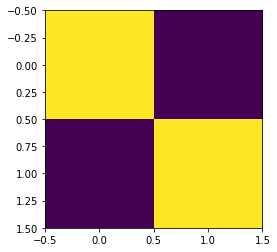

In [18]:
plt.imshow(cond_mat)

In [21]:
d = MultivariateNormal(
    torch.tensor([10.0, 5, 1]),
    torch.tensor([[100.0, 30.0, 0], [30.0, 10.0, 0], [0, 0, 1.0]]),
)
cond_mat = av_conditional_corr_matrix(
    density=d,
    limits=torch.tensor([[-60.0, 60.0], [-20, 20], [-7, 7]]),
    resolution=500,
)
corr_dim12 = torch.sqrt(torch.tensor(30.0 ** 2 / 100.0 / 10.0))
gt_matrix = torch.tensor(
    [[1.0, corr_dim12, 0.0], [corr_dim12, 1.0, 0.0], [0.0, 0.0, 1.0]]
)

print(torch.abs(gt_matrix - cond_mat))

tensor([[0.0000e+00, 1.1325e-06, 8.9154e-07],
        [1.1325e-06, 0.0000e+00, 1.0341e-06],
        [8.9154e-07, 1.0341e-06, 0.0000e+00]])


# Run full test in 3D case

In [26]:
joint_mean = torch.zeros(3)
joint_cov = torch.tensor([[1.0, 0.95, 0.95], [0.95, 1.0, 0.95], [0.95, 0.95, 1.0]])
d = MultivariateNormal(joint_mean, joint_cov)
condition_2 = torch.ones(2)
full_condition = torch.ones(3)

resolution = 100
vals_to_eval_at = torch.linspace(-3, 3, resolution)

### Plot marginal

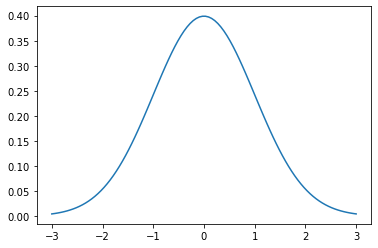

In [27]:
d_1D = Normal(joint_mean[0], joint_cov[0,0])

probs = torch.exp(d_1D.log_prob(vals_to_eval_at))
plt.plot(vals_to_eval_at, probs)

### Conditional with SNPE

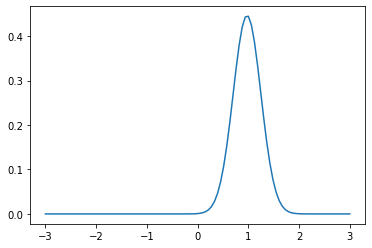

In [28]:
probs = eval_conditional_density(
    pdf=d,
    condition=full_condition,
    limits=torch.tensor([[-3, 3], [-3, 3], [-3, 3]]),
    dim1=0,
    dim2=0,
    resolution=resolution,
)
plt.plot(vals_to_eval_at, probs)

### True conditional

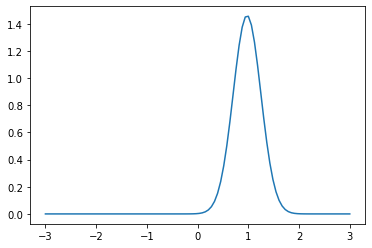

In [29]:
mean_1 = joint_mean[0]
mean_2 = joint_mean[1:]
cov_11 = joint_cov[0, 0]
cov_12 = joint_cov[0, 1:]
cov_22 = joint_cov[1:, 1:]

precision_observed = torch.inverse(cov_22)  # i.e. gram matrix for BI

residual = condition_2 - mean_2
precision_weighted_residual = torch.mv(precision_observed, residual)
project_to_relevant = torch.dot(cov_12, precision_weighted_residual)
condiotional_1Dmean = mean_1 + project_to_relevant

conditional_1Dcov = cov_11 - torch.dot(cov_12, torch.mv(precision_observed, cov_12))
conditional_dist = torch.distributions.Normal(condiotional_1Dmean, torch.sqrt(conditional_1Dcov))

probs = torch.exp(conditional_dist.log_prob(vals_to_eval_at))
plt.plot(vals_to_eval_at, probs)

# Full test suite for 3D joint, conditioning on one value, obtaining a 2D dist.

In [43]:
joint_mean = torch.tensor([-1, 0.5, 2.0])
joint_cov = torch.tensor([[1.0, 0.0, 0.7], [0.0, 1.0, 0.7], [0.7, 0.7, 1.0]])
d = MultivariateNormal(joint_mean, joint_cov)
condition_2 = torch.ones(1)
full_condition = torch.ones(3)

resolution = 100
vals_to_eval_at_dim1 = torch.linspace(-3, 3, resolution).repeat(resolution).unsqueeze(1)
vals_to_eval_at_dim2 = torch.repeat_interleave(torch.linspace(-3, 3, resolution), resolution).unsqueeze(1)
vals_to_eval_at = torch.cat((vals_to_eval_at_dim1, vals_to_eval_at_dim2), axis=1)

In [44]:
joint_cov

tensor([[1.0000, 0.0000, 0.7000],
        [0.0000, 1.0000, 0.7000],
        [0.7000, 0.7000, 1.0000]])

### Plot 2D marginal

In [45]:
vals_to_eval_at.shape

torch.Size([10000, 2])

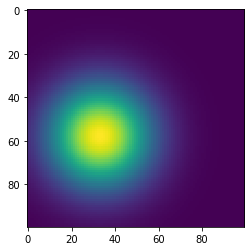

In [46]:
d_2D = MultivariateNormal(joint_mean[:2], joint_cov[:2, :2])

probs = torch.exp(d_2D.log_prob(vals_to_eval_at))
probs = torch.reshape(probs, (resolution, resolution))
plt.imshow(probs)

### Conditional with sbi

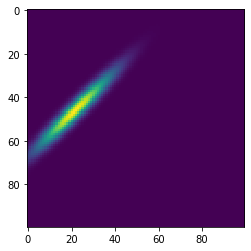

In [55]:
probs = eval_conditional_density(
    pdf=d,
    condition=full_condition,
    limits=torch.tensor([[-3, 3], [-3, 3], [-3, 3]]),
    dim1=0,
    dim2=1,
    resolution=resolution,
)
probs_sbi = probs / torch.sum(probs)
plt.imshow(probs_sbi)

### Analytical conditonal

torch.Size([1, 1])


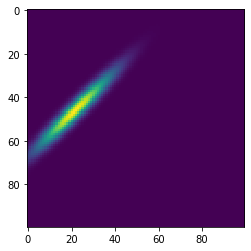

In [56]:
mean_1 = joint_mean[:2]
mean_2 = joint_mean[2:]
cov_11 = joint_cov[:2, :2]
cov_12 = joint_cov[:2, 2:]
cov_22 = joint_cov[2:, 2:]

precision_observed = torch.inverse(cov_22)  # i.e. gram matrix for BI
print(precision_observed.shape)
residual = condition_2 - mean_2
precision_weighted_residual = torch.einsum('ij, i -> j', precision_observed, residual)
project_to_relevant = torch.mv(cov_12, precision_weighted_residual)
condiotional_2Dmean = mean_1 + project_to_relevant

prec_cov = torch.einsum('ji, kj -> ik', precision_observed, cov_12)
cov_prec_cov = torch.einsum('ij, jk -> ik', cov_12, prec_cov)
conditional_2Dcov = cov_11 - cov_prec_cov
conditional_dist = torch.distributions.MultivariateNormal(condiotional_2Dmean, conditional_2Dcov)

probs = torch.exp(conditional_dist.log_prob(vals_to_eval_at))
probs = torch.reshape(probs, (resolution, resolution))
probs_analytical = probs / torch.sum(probs)
plt.imshow(probs_analytical)

In [253]:
torch.abs(probs_analytical - probs_sbi).shape

torch.Size([100, 100])

In [261]:
torch.all(torch.abs(probs_analytical - probs_sbi) < 1e-5)

tensor(True)

# Run stuff from tests

In [278]:
def conditional_density_2d():
    """
    Test whether the conditional density matches analytical results for MVN.
    """
    joint_mean = torch.zeros(3)
    joint_cov = torch.tensor([[1.0, 0.0, 0.7], [0.0, 1.0, 0.7], [0.7, 0.7, 1.0]])
    joint_dist = MultivariateNormal(joint_mean, joint_cov)

    condition_dim2 = torch.ones(1)
    full_condition = torch.ones(3)

    resolution = 100
    vals_to_eval_at_dim1 = (
        torch.linspace(-3, 3, resolution).repeat(resolution).unsqueeze(1)
    )
    vals_to_eval_at_dim2 = torch.repeat_interleave(
        torch.linspace(-3, 3, resolution), resolution
    ).unsqueeze(1)
    vals_to_eval_at = torch.cat((vals_to_eval_at_dim1, vals_to_eval_at_dim2), axis=1)

    # Solution with sbi.
    probs = eval_conditional_density(
        pdf=joint_dist,
        condition=full_condition,
        limits=torch.tensor([[-3, 3], [-3, 3], [-3, 3]]),
        dim1=0,
        dim2=1,
        resolution=resolution,
    )
    probs_sbi = probs / torch.sum(probs)

    # Analytical solution.

    conditional_2Dmean, conditional_2Dcov = conditional_of_mvn(
        joint_mean, joint_cov, condition_dim2
    )
    conditional_dist = torch.distributions.MultivariateNormal(
        conditional_2Dmean, conditional_2Dcov
    )

    probs = torch.exp(conditional_dist.log_prob(vals_to_eval_at))
    probs = torch.reshape(probs, (resolution, resolution))
    probs_analytical = probs / torch.sum(probs)

    assert torch.all(torch.abs(probs_analytical - probs_sbi) < 1e-5)


def conditional_of_mvn(joint_mean, joint_cov, condition):
    """
    Return the mean and cov of a conditional Gaussian.

    We assume that we always condtion on the last variables. 
    """

    mean_1 = joint_mean[:num_of_condition_dims]
    mean_2 = joint_mean[num_of_condition_dims:]
    cov_11 = joint_cov[:num_of_condition_dims, :num_of_condition_dims]
    cov_12 = joint_cov[:num_of_condition_dims, num_of_condition_dims:]
    cov_22 = joint_cov[num_of_condition_dims:, num_of_condition_dims:]

    precision_observed = torch.inverse(cov_22)  # i.e. gram matrix for BI
    residual = condition - mean_2
    precision_weighted_residual = torch.einsum(
        "ij, i -> j", precision_observed, residual
    )
    project_to_relevant = torch.mv(cov_12, precision_weighted_residual)
    condiotional_2Dmean = mean_1 + project_to_relevant

    prec_cov = torch.einsum("ji, kj -> ik", precision_observed, cov_12)
    cov_prec_cov = torch.einsum("ij, jk -> ik", cov_12, prec_cov)
    conditional_2Dcov = cov_11 - cov_prec_cov

    return condiotional_2Dmean, conditional_2Dcov


In [280]:
conditional_density_2d()

2


In [301]:
def conditional_density_2d():
    """
    Test whether the conditional density matches analytical results for MVN.
    """
    joint_mean = torch.zeros(3)
    joint_cov = torch.tensor([[1.0, 0.0, 0.7], [0.0, 1.0, 0.7], [0.7, 0.7, 1.0]])
    joint_dist = MultivariateNormal(joint_mean, joint_cov)

    condition_dim2 = torch.ones(2)
    full_condition = torch.ones(3)

    resolution = 100
    vals_to_eval_at = torch.linspace(-3, 3, resolution).unsqueeze(1)

    # Solution with sbi.
    probs = eval_conditional_density(
        pdf=joint_dist,
        condition=full_condition,
        limits=torch.tensor([[-3, 3], [-3, 3], [-3, 3]]),
        dim1=0,
        dim2=0,
        resolution=resolution,
    )
    probs_sbi = probs / torch.sum(probs)

    # Analytical solution.

    conditional_2Dmean, conditional_2Dcov = conditional_of_mvn(
        joint_mean, joint_cov, condition_dim2
    )
    conditional_dist = torch.distributions.MultivariateNormal(
        conditional_2Dmean, conditional_2Dcov
    )

    probs = torch.exp(conditional_dist.log_prob(vals_to_eval_at))
    probs_analytical = probs / torch.sum(probs)

    print(torch.abs(probs_analytical - probs_sbi))
    assert torch.all(torch.abs(probs_analytical - probs_sbi) < 1e-5)


def conditional_of_mvn(joint_mean, joint_cov, condition):
    """
    Return the mean and cov of a conditional Gaussian.

    We assume that we always condtion on the last variables. 
    """
    
    num_of_condition_dims = joint_mean.shape[0] - condition.shape[0]

    mean_1 = joint_mean[:num_of_condition_dims]
    mean_2 = joint_mean[num_of_condition_dims:]
    cov_11 = joint_cov[:num_of_condition_dims, :num_of_condition_dims]
    cov_12 = joint_cov[:num_of_condition_dims, num_of_condition_dims:]
    cov_22 = joint_cov[num_of_condition_dims:, num_of_condition_dims:]

    precision_observed = torch.inverse(cov_22)  # i.e. gram matrix for BI
    residual = condition - mean_2
    precision_weighted_residual = torch.einsum(
        "ij, i -> j", precision_observed, residual
    )
    project_to_relevant = torch.mv(cov_12, precision_weighted_residual)
    condiotional_2Dmean = mean_1 + project_to_relevant

    prec_cov = torch.einsum("ji, kj -> ik", precision_observed, cov_12)
    cov_prec_cov = torch.einsum("ij, jk -> ik", cov_12, prec_cov)
    conditional_2Dcov = cov_11 - cov_prec_cov

    return condiotional_2Dmean, conditional_2Dcov


In [302]:
conditional_density_2d()

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.9427e-44, 2.3710e-42, 6.0446e-41, 5.4183e-39, 7.7877e-38,
        7.1235e-36, 1.4933e-34, 2.4435e-33, 1.3443e-31, 5.7192e-30, 6.9420e-29,
        1.7860e-27, 2.3931e-26, 4.2813e-25, 4.1359e-25, 3.0606e-23, 7.3454e-22,
        1.7047e-20, 7.8774e-20, 3.3881e-19, 9.7578e-18, 6.3317e-17, 6.2450e-16,
        2.4425e-15, 9.3259e-15, 1.6165e-13, 7.6028e-13, 4.5475e-13, 8.4128e-12,
        2.4556e-11, 1.1642e-10, 2.9104e-10, 4.3656e-10, 3.4925e-10, 4.6566e-09,
        1.3970e-09, 2.7940e-09, 9.3132e-09, 7.4506e-09, 1.1176e-08, 1.4901e-08,
        0.0000e+00, 7.4506e-09, 7.4506e-09, 0.0000e+00, 7.4506e-09, 1.4901e-08,
        5.2154e-08, 2.6077e-08, 2.4214e-08, 3.1665e-08, 1.6298e-08, 4.1910e-09,
        3.8417e-09, 1.8626e-09, 6.6939e-10, 2.9831e-10, 1.2369e-10, 1.8645e-11,
        6.7075e-12, 1.7053e-12, 3.4461e-

In [256]:
condiotional_1Dmean

tensor([0.9500, 0.0000])

In [ ]:
_ = pairplot(
    samples = d.sample((100000,)),
    pdfs=[d],
    condition = torch.zeros(1, 3),
    limits = torch.tensor([[-3.0, 3.0], [-3, 3], [-3, 3]]),
#     upper = ['cond'],
#     diag = ['cond']
)

In [137]:
# vec = eval_conditional_density(d, torch.tensor([[1.0, 1.0, 0.0]]), limits=torch.tensor([[-0.2, 0.2], [-20, 20], [-2, 2]]), dim1=0, dim2=1, resolution=50)
vec = eval_conditional_density(d, torch.tensor([[0.0, 0.0]]), limits=torch.tensor([[-0.4, 0.4], [-40, 40]]), dim1=0, dim2=1, resolution=50)
vec_np = vec.numpy()

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

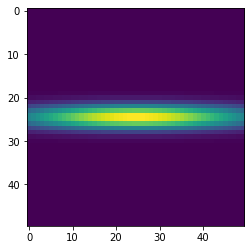

In [110]:
plt.imshow(vec_np)

In [116]:
# vec = eval_conditional_density(d, torch.tensor([[1.0, 1.0, 0.0]]), limits=torch.tensor([[-0.2, 0.2], [-20, 20], [-2, 2]]), dim1=0, dim2=0, resolution=50)
vec = eval_conditional_density(d, torch.tensor([[0.0, 0.0]]), limits=torch.tensor([[-0.4, 0.4], [-40, 40]]), dim1=0, dim2=0, resolution=50)
vec_np = vec.numpy()

tensor([[-0.4000,  0.0000],
        [-0.3837,  0.0000],
        [-0.3673,  0.0000],
        [-0.3510,  0.0000],
        [-0.3347,  0.0000],
        [-0.3184,  0.0000],
        [-0.3020,  0.0000],
        [-0.2857,  0.0000],
        [-0.2694,  0.0000],
        [-0.2531,  0.0000],
        [-0.2367,  0.0000],
        [-0.2204,  0.0000],
        [-0.2041,  0.0000],
        [-0.1878,  0.0000],
        [-0.1714,  0.0000],
        [-0.1551,  0.0000],
        [-0.1388,  0.0000],
        [-0.1224,  0.0000],
        [-0.1061,  0.0000],
        [-0.0898,  0.0000],
        [-0.0735,  0.0000],
        [-0.0571,  0.0000],
        [-0.0408,  0.0000],
        [-0.0245,  0.0000],
        [-0.0082,  0.0000],
        [ 0.0082,  0.0000],
        [ 0.0245,  0.0000],
        [ 0.0408,  0.0000],
        [ 0.0571,  0.0000],
        [ 0.0735,  0.0000],
        [ 0.0898,  0.0000],
        [ 0.1061,  0.0000],
        [ 0.1224,  0.0000],
        [ 0.1388,  0.0000],
        [ 0.1551,  0.0000],
        [ 0.1714,  0

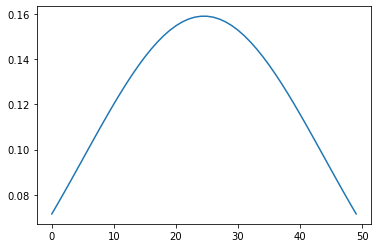

In [117]:
plt.plot(vec_np)

In [123]:
import numpy as np
a = torch.randn(10000) * np.sqrt(0.1)

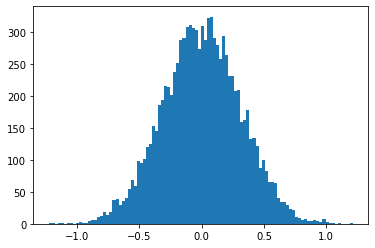

In [125]:
_ = plt.hist(a, bins=100)